# Title:

## Introduction

## Preliminary Results

In [1]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [17]:
# Read the data downloaded from web and cleaning the data
# It contains 424 individuals
ch_data <- read_csv("/home/jovyan/work/stat-201/group-project/cirrhosis.csv") |>
            select(N_Days, Status, Age, Drug, Sex, Ascites) |>
            mutate(Age = floor(Age / 365)) |>
            rename(n_days = N_Days,
                   status = Status,
                      age = Age,
                     drug = Drug,
                      sex = Sex,
                  ascites = Ascites)                                        
head(ch_data)

Rows: 418 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Status, Drug, Sex, Ascites, Hepatomegaly, Spiders, Edema
dbl (13): ID, N_Days, Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


n_days,status,age,drug,sex,ascites
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
400,D,58,D-penicillamine,F,Y
4500,C,56,D-penicillamine,F,N
1012,D,70,D-penicillamine,M,N
1925,D,54,D-penicillamine,F,N
1504,CL,38,Placebo,F,N
2503,D,66,Placebo,F,N


In [30]:
#Preparing different samples

ch_sample <- ch_data |>
             select(n_days, drug) |>
             filter(!is.na(n_days))|>
             filter(!is.na(drug))

ch_sample_p <- ch_data |>
               select(n_days, drug) |>
               filter(drug == "Placebo")

ch_sample_d <- ch_data |>
               select(n_days, drug) |>
               filter(drug == "D-penicillamine")

head(ch_sample_p)
head(ch_sample_d)

n_days,drug
<dbl>,<chr>
1504,Placebo
2503,Placebo
1832,Placebo
2466,Placebo
51,Placebo
3762,Placebo


n_days,drug
<dbl>,<chr>
400,D-penicillamine
4500,D-penicillamine
1012,D-penicillamine
1925,D-penicillamine
2400,D-penicillamine
3584,D-penicillamine


In [13]:
#Build the bootstrapping distribution using mean of n-days.

set.seed(9999)
ch_p_boots <- ch_sample_p %>% 
                specify(response = n_days) %>% 
                generate(type = "bootstrap", reps = 1000) %>% 
                calculate(stat = "mean")
ch_p_ci <- ch_p_boots |>
            get_ci(level = 0.95, type = "percentile")

ch_d_boots <- ch_sample_d %>% 
                specify(response = n_days) %>% 
                generate(type = "bootstrap", reps = 1000) %>% 
                calculate(stat = "mean")
ch_d_ci <- ch_d_boots |>
            get_ci(level = 0.95, type = "percentile")

ch_p_ci
ch_d_ci

lower_ci,upper_ci
<dbl>,<dbl>
1812.148,2180.825


lower_ci,upper_ci
<dbl>,<dbl>
1850.069,2181.481


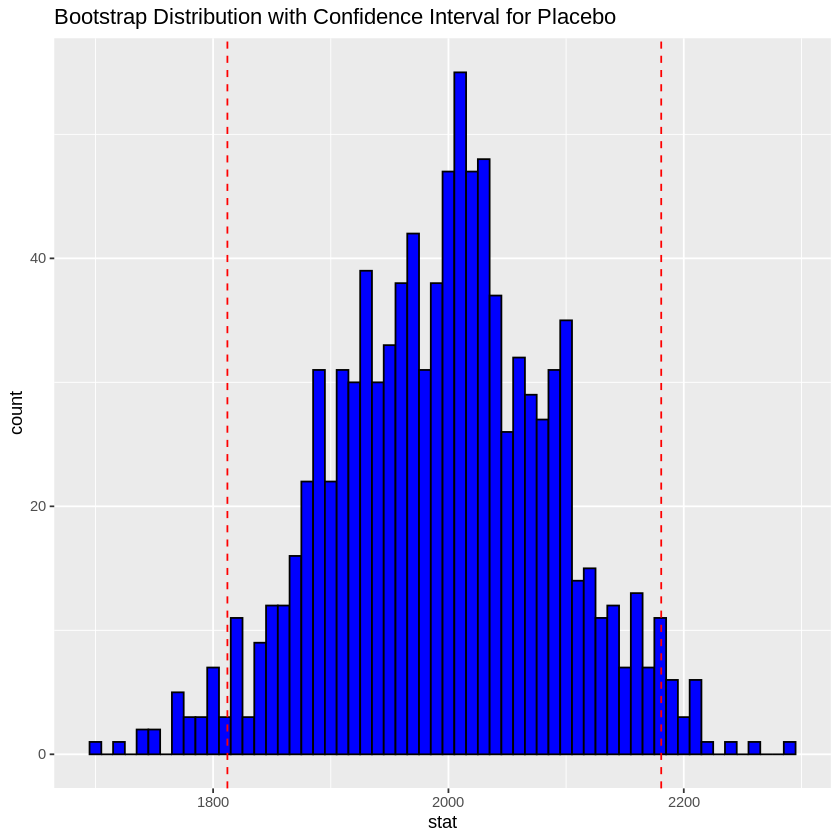

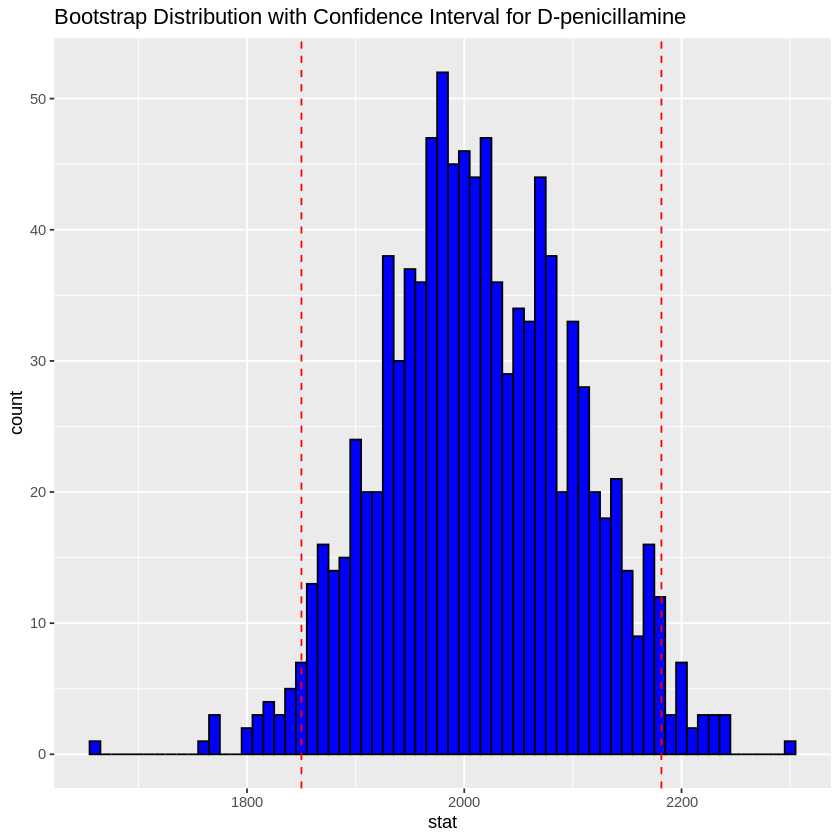

In [32]:
#Visualize them.
ch_p_plot <- ggplot(ch_p_boots, aes(x = stat)) +
              geom_histogram(binwidth = 10, fill = "blue", color = "black") +  
              geom_vline(xintercept = as.numeric(ch_p_ci[1]), color = "red", linetype = "dashed") +
              geom_vline(xintercept = as.numeric(ch_p_ci[2]), color = "red", linetype = "dashed") +
              labs(title = "Bootstrap Distribution with Confidence Interval for Placebo")

ch_d_plot <- ggplot(ch_d_boots, aes(x = stat)) +
              geom_histogram(binwidth = 10, fill = "blue", color = "black") +  
              geom_vline(xintercept = as.numeric(ch_d_ci[1]), color = "red", linetype = "dashed") +
              geom_vline(xintercept = as.numeric(ch_d_ci[2]), color = "red", linetype = "dashed") +
              labs(title = "Bootstrap Distribution with Confidence Interval for D-penicillamine")

ch_p_plot
ch_d_plot

In [31]:
#Build the bootstrapping distribution using Propotions.
ch_prop_p <- ch_sample |>
             specify(response = drug, success = "Placebo") |>
             generate(type = "bootstrap", reps = 1000) |>
             calculate(stat = "prop")
ch_p_prop_ci <- ch_prop_p |>
                get_ci(level = 0.95, type = "percentile")

ch_prop_d <- ch_sample |>
             specify(response = drug, success = "D-penicillamine") |>
             generate(type = "bootstrap", reps = 1000) |>
             calculate(stat = "prop")
ch_d_prop_ci <- ch_prop_d |>
                get_ci(level = 0.95, type = "percentile")
ch_p_prop_ci
ch_d_prop_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.4519231,0.5608974


lower_ci,upper_ci
<dbl>,<dbl>
0.4519231,0.5608974


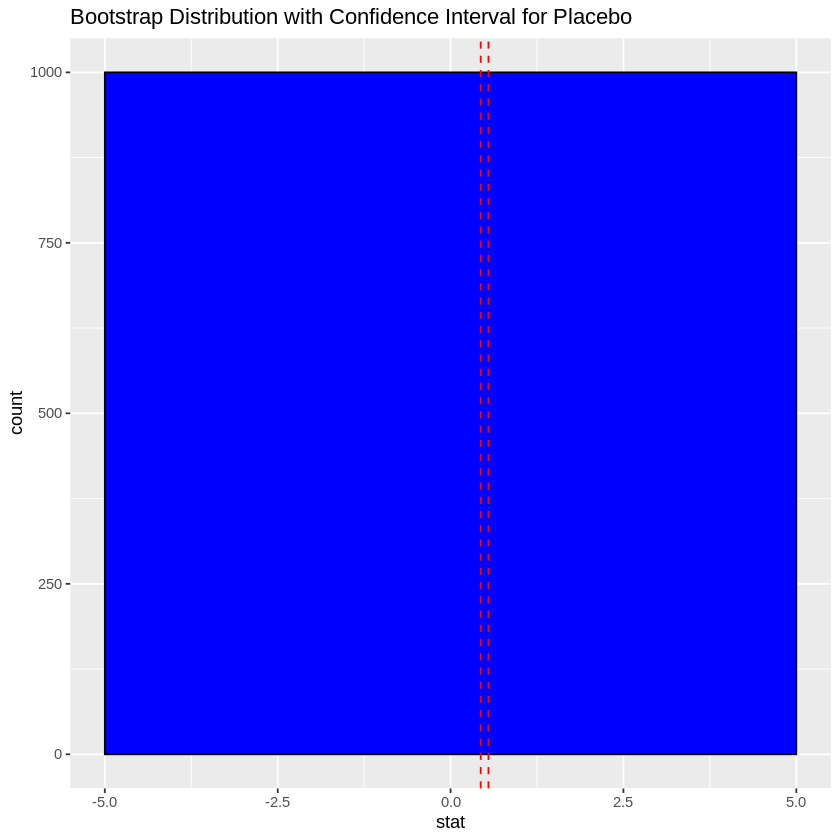

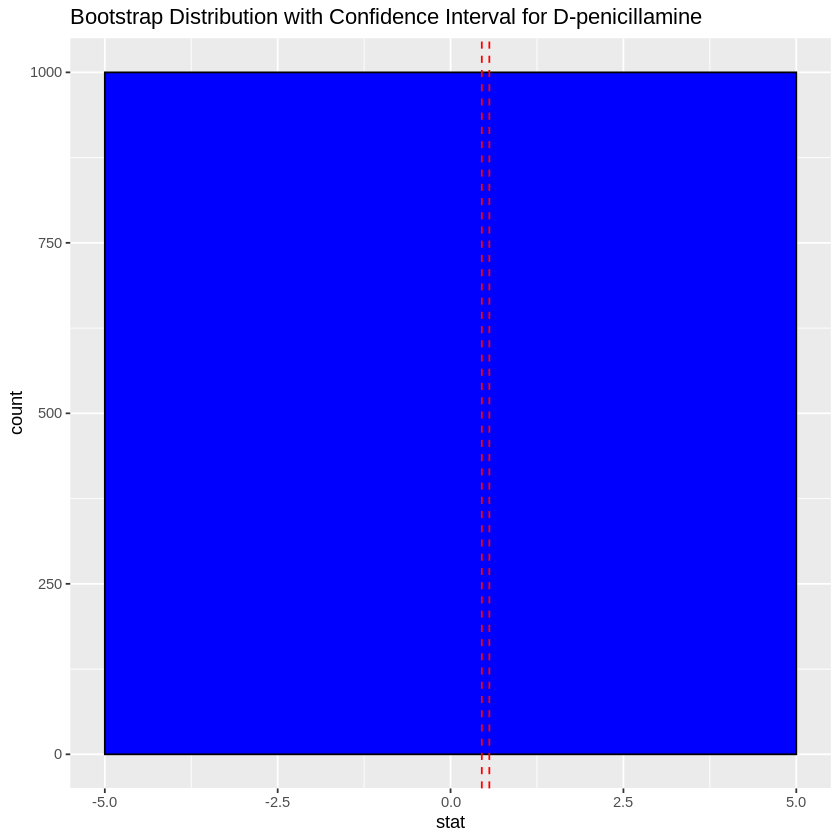

In [34]:
#Visualize them.
ch_prop_p_plot <- ggplot(ch_prop_p, aes(x = stat)) +
              geom_histogram(fill = "blue", color = "black") +  
              geom_vline(xintercept = as.numeric(ch_p_prop_ci[1]), color = "red", linetype = "dashed") +
              geom_vline(xintercept = as.numeric(ch_p_prop_ci[2]), color = "red", linetype = "dashed") +
              labs(title = "Bootstrap Distribution with Confidence Interval for Placebo")

ch_prop_d_plot <- ggplot(ch_prop_d, aes(x = stat)) +
              geom_histogram(binwidth = 10, fill = "blue", color = "black") +  
              geom_vline(xintercept = as.numeric(ch_d_prop_ci[1]), color = "red", linetype = "dashed") +
              geom_vline(xintercept = as.numeric(ch_d_prop_ci[2]), color = "red", linetype = "dashed") +
              labs(title = "Bootstrap Distribution with Confidence Interval for D-penicillamine")

ch_prop_p_plot
ch_prop_d_plot

## Methods: Plan


## References
